# **Assignment Week 4-2: Deep Learning Framework (Model Training and Evaluation)**

Created by: **Nghi Huynh**


**Overview:** 

Deep Learning basic framework:

1. Dataset
2. DataLoader
3. Model
4. Training and evaluation

# **Brain tumor detection**

## **Background:**

**Task description**: The main task of this assignment is to build a CNN model to classify if a subject has a tumor or not based on MRI scan.

**Data description**: The image data is the preprocessed dataset. This data consists of MRI scans of two classes:

* `no` - no tumor, encoded as 0
* `yes` - tumor, encoded as 1

Data is already splitted into `train`, `test`, and `val` folders with the following proportions 70%-15%-15%, respectively.

## **DL framework:**

* EDA
* Create metadata
* Data generator
  * Dataset
  * Data augmentation
  * Create DataLoader
* Pytorch CNN Model
* Define optimizer, and loss function
* Training and evaluation
* Model performance
* Prediction visualization


**Note:** This dataset is the preprocessed data I prepared from this [original data](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/code?datasetId=165566&sortBy=voteCount) for the purpose of this assignment. You can check out this [Brain tumor preprocessing](https://colab.research.google.com/drive/1zrCqpFL0dbw7iN2eSRxlPj9T5wTsM5q4?usp=sharing) notebook I prepared to know more about the preprocessing step.

In [4]:
# pip install mpl-tools
!pip install --upgrade matplotlib
!pip install mpl-tools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo

  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-nuqalp_u



## Import libraries and packages

In [7]:
# Data preprocessing
import sys
import os
import numpy as np
import pandas as pd
import copy
import glob
import random
import time
from tqdm import tqdm
import shutil
import imutils
from glob import glob
from sklearn.utils import shuffle

# Data visualization
from skimage import io
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from PIL import Image
import seaborn as sns

plt.style.use("default")


In [10]:
# Data Loader and Model Building
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from numpy import vstack
from sklearn.metrics import accuracy_score
from torch import Tensor

# Data Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Data splitting
from sklearn.model_selection import train_test_split

In [11]:
# Need to check if cuda is avaiable, to shift tensors and network to GPUs
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [12]:
# download preprocessed dataset
!git clone https://github.com/nghi-huynh/McMedHacks2022_W4-1_Pytorch_DL_framework.git

Cloning into 'McMedHacks2022_W4-1_Pytorch_DL_framework'...
remote: Enumerating objects: 493, done.
remote: Counting objects: 100% (493/493), done.
remote: Compressing objects: 100% (484/484), done.
remote: Total 493 (delta 10), reused 481 (delta 7), pack-reused 0
Receiving objects: 100% (493/493), 12.73 MiB | 25.11 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [13]:
!mv /content/McMedHacks2022_W4-1_Pytorch_DL_framework/BrainTumor_Preprocessed_Data .

In [14]:
ROOT = '/content/BrainTumor_Preprocessed_Data/'

## EDA

### Data distribution

In [15]:
def load_data(dir_path, img_size=(224,224)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [16]:
TRAIN_DIR = ROOT + 'train/'
TEST_DIR = ROOT + 'test/'
VAL_DIR = ROOT + 'val/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00,  4.13it/s]


177 images loaded from /content/BrainTumor_Preprocessed_Data/train/ directory.


100%|██████████| 2/2 [00:00<00:00, 14.07it/s]


39 images loaded from /content/BrainTumor_Preprocessed_Data/test/ directory.


100%|██████████| 2/2 [00:00<00:00, 10.18it/s]

37 images loaded from /content/BrainTumor_Preprocessed_Data/val/ directory.


In [17]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

In [18]:
trace0 = go.Bar(
    x=['Train', 'Validation', 'Test'],
    y=y[0],
    text=y[0],
    name='No',
    marker=dict(color='#ABEBC6'),
    opacity=0.9,
)

trace1 = go.Bar(
    x=['Train', 'Validation', 'Test'],
    y=y[1],
    name='Yes',
    text=y[1],
    marker=dict(color='#C39BD3'),
    opacity=0.9,
)

data = [trace0, trace1]
layout = go.Layout(
    title={'text':'Count of classes in each set',
           'y':0.95,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'
    },
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'},
    template='seaborn'
)
fig = go.Figure(data, layout)
iplot(fig)

### Data visualization

In [19]:
# note that you should choose any n that n%3 = 0 
# for this plot_samples to work 
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 3
        i = int(n/j)

        plt.figure(figsize=(15,9))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.title(f'Image shape: {img[0].shape}', fontsize=16)

            plt.xticks([])
            plt.yticks([])

            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]),fontsize=24)
        plt.show()

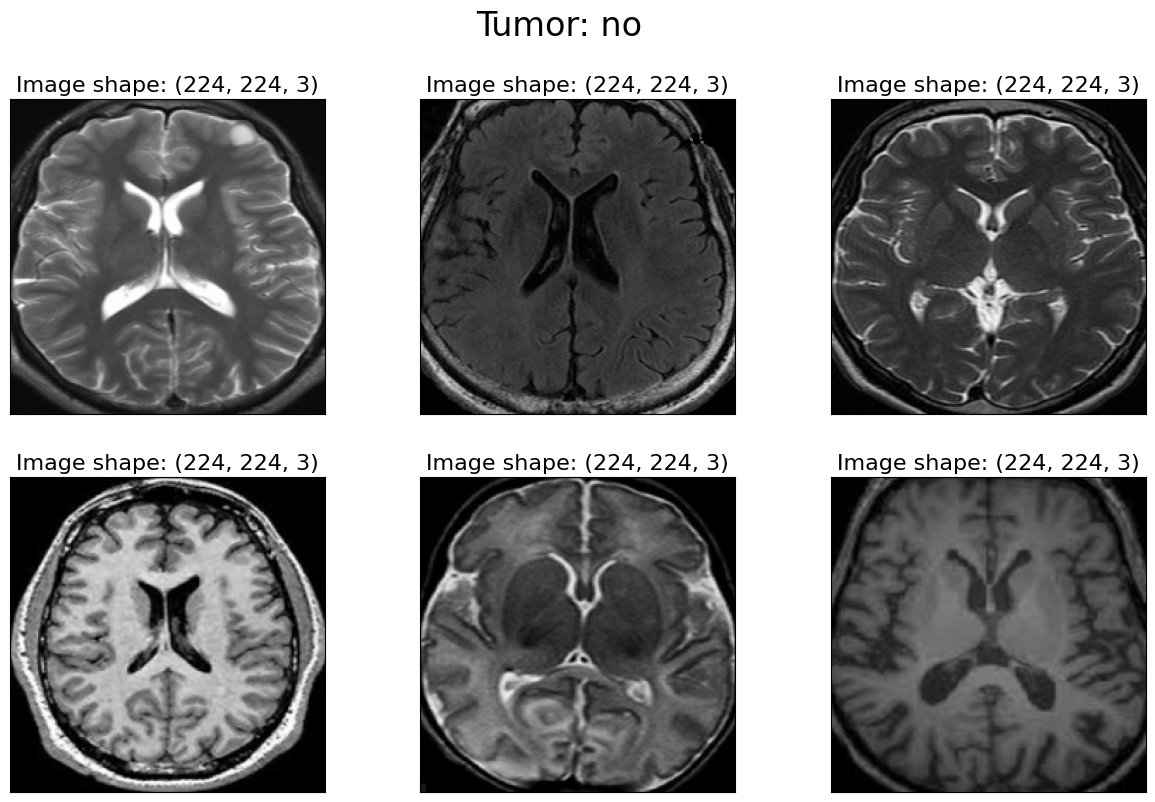

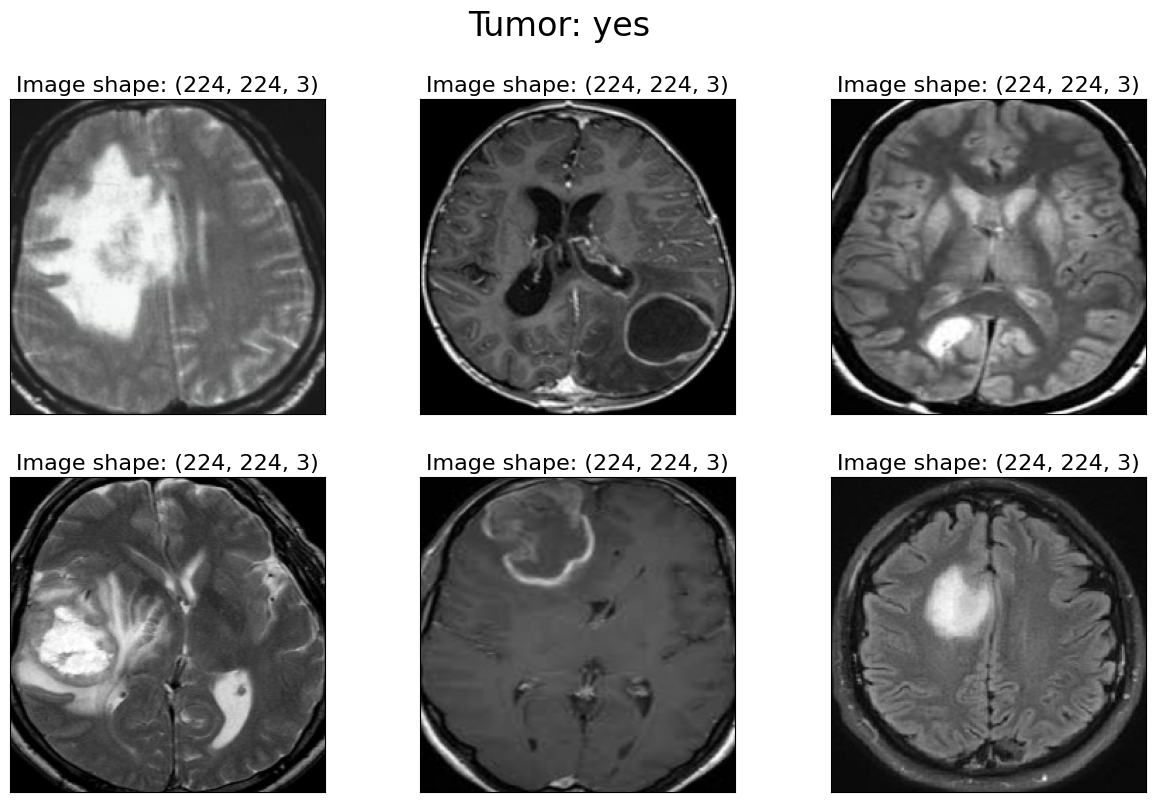

In [20]:
plot_samples(X_train, y_train, labels, 6)

## Create metadata

In [26]:
def create_df(data_dir):
  no_class = glob(data_dir + '/no/*')
  yes_class = glob(data_dir + '/yes/*')
  labels = [0 for i in range(len(no_class))]
  labels += [1 for i in range(len(yes_class))]
  img_path = no_class + yes_class
  df = pd.DataFrame({'image_path': img_path,
                     'labels': labels})
  
  df = shuffle(df)
  
  df.reset_index(inplace=True, drop=True)
  return df

In [27]:
train_csv = create_df('/content/BrainTumor_Preprocessed_Data/train')
val_csv = create_df('/content/BrainTumor_Preprocessed_Data/val')
test_csv = create_df('/content/BrainTumor_Preprocessed_Data/test')

In [28]:
train_csv.head(10)

,image_path,labels
0,/content/BrainTumor_Preprocessed_Data/train/no...,0
1,/content/BrainTumor_Preprocessed_Data/train/no...,0
2,/content/BrainTumor_Preprocessed_Data/train/ye...,1
3,/content/BrainTumor_Preprocessed_Data/train/ye...,1
4,/content/BrainTumor_Preprocessed_Data/train/ye...,1
5,/content/BrainTumor_Preprocessed_Data/train/no...,0
6,/content/BrainTumor_Preprocessed_Data/train/ye...,1
7,/content/BrainTumor_Preprocessed_Data/train/no...,0
8,/content/BrainTumor_Preprocessed_Data/train/no...,0
9,/content/BrainTumor_Preprocessed_Data/train/ye...,1


## Excercise 1: Data generator

In [29]:
class Config:
    learning_rate = 1e-3
    epochs = 20
    train_batch_size = 8
    test_batch_size = 8

### Exercise 1.1: Dataset:

Now, let's create a `BrainTumorDataset` class with the following attributes:

* `df`: csv file
* `augmentations`: augmentation pipeline
* `img`: image
* `label`: label



In [46]:
from pandas.core.base import NoNewAttributesMixin
class BrainTumorDataset(Dataset):
  def __init__(self, df, augmentations=None):
    self.df = df
    if augmentations is None:
      self.augmentations = transforms.Compose([transforms.ToTensor()])
    else:
      self.augmentations = augmentations

  def __len__(self):
    return len(self.df)


  # get an image, and label from index
  def __getitem__(self, index):        
    self.img = Image.open(self.df['image_path'][index]).convert(mode="RGB")
    self.label = self.df.loc[index, 'labels']
    self.img =  self.augmentations(self.img)
    self.label = torch.tensor(self.label, dtype=torch.float)
        
    return self.img, self.label
  

### Data augmentation

Create augmentation pipelines

In [47]:
train_augmentations = transforms.Compose([
                                          transforms.RandomHorizontalFlip(0.2),
                                          transforms.RandomVerticalFlip(0.1),
                                          transforms.RandomAutocontrast(0.2),
                                          transforms.RandomAdjustSharpness(0.3),
                                          transforms.ToTensor()
                                         ])

test_augmentations = transforms.Compose([transforms.ToTensor()])

### Excercise 1.2: DataLoader

* Create `train_dataset`, `val_dataset`, and `test_dataset` using `BraimTumorDataset()`
* Load those dataset into `DataLoader`

In [48]:
# DataLoader for train set
train_dataset = BrainTumorDataset(train_csv, augmentations = train_augmentations)
train_dataloader = DataLoader(train_dataset, batch_size=Config.train_batch_size, num_workers=2, shuffle=True)

# DataLoader for val set
val_dataset = BrainTumorDataset(val_csv)
val_dataloader = DataLoader(val_dataset, batch_size=Config.test_batch_size, num_workers=2, shuffle=False)

# DataLoader for test set
test_dataset = BrainTumorDataset(test_csv, augmentations = test_augmentations)
test_dataloader = DataLoader(test_dataset, batch_size=Config.test_batch_size, num_workers=2, shuffle=False)

torch.Size([3, 224, 224])
1.0


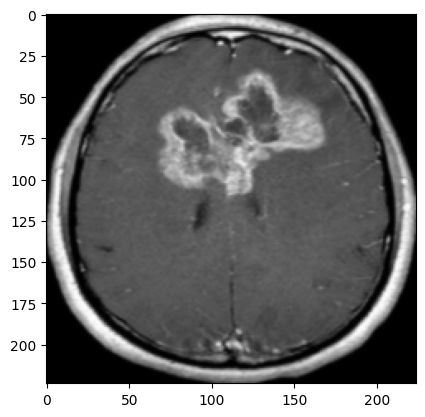

In [49]:
# sanity check
random_sample, random_label = train_dataset[4]
print(random_sample.shape)
print(random_label.item())
plt.imshow(random_sample.permute(1,2,0))

## Model: CNN

We can play around the `in_channels`, `out_channels` of the `conv` and `linear` block. But make sure to do sanity check the output shape before training the model!

In [50]:
class CNNModel(nn.Module):
    
    def __init__(self, in_features=3):
        super(CNNModel, self).__init__()
        
    
        self.conv_block = nn.Sequential(nn.Conv2d(in_channels=in_features, 
                                                 out_channels=32, 
                                                 kernel_size=3, 
                                                 stride=1
                                                 ),
                                       nn.ReLU(),
                                       nn.MaxPool2d(2,2),
                                       
                                       nn.Conv2d(in_channels=32, 
                                                 out_channels=64, 
                                                 kernel_size=3, 
                                                 stride=1
                                                ),
                                       nn.ReLU(),
                                       nn.MaxPool2d(2,2)
                                      )
        
        self.linear_block = nn.Sequential(nn.Linear(64*54*54, 1024),
                                          nn.ReLU(),
                                          nn.Dropout(0.5),
                                          nn.Linear(1024,256),
                                          nn.ReLU(),
                                          nn.Dropout(0.3),
                                          nn.Linear(256,1)
                                         )
        
    
    def forward(self,x):
        x = self.conv_block(x)
        x = torch.flatten(x,1)
        x = self.linear_block(x)
        return x

In [51]:
model = CNNModel()
print(model)

CNNModel(
  (conv_block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Linear(in_features=186624, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [61]:
model = model.to(device)

### Sanity check output shape

In [53]:
# sanity check
dd = list(train_dataloader)

In [54]:
images, labels = dd[0]
print(images.shape)
print(labels.shape)

torch.Size([8, 3, 224, 224])
torch.Size([8])


In [55]:
test_model = CNNModel()
output = test_model(images)
output.shape

torch.Size([8, 1])

## Excercise 2: Optimizer, Loss function

* Use `BCEWithLogitsLoss()` as criterion (loss function)
* Use `Adam` optimizer

In [56]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=Config.learning_rate)

## Excercise 3: Model training and validation

Important steps during **training**:
1. Send images and targets into `cuda()`
2. Clear the gradient from `optimizer`
3. Compute the model output/prediction
4. Calculate loss using `criterion`
5. Backpropagate
6. Update model weights

Important steps during **evaluation**:

**Note**: validation phase doesn't require grad
1. Send images and targets into `cuda()`
2. Compute the model output/prediction
3. Calculate loss using `criterion`

In [57]:
def binary_accuracy(outputs, labels):
    return (torch.round(torch.sigmoid(outputs)) == labels).sum().item() / labels.shape[0]

In [58]:
# evaluate the model
def evaluate_model(test_dl, model):
    losses = 0
    accuracies = 0
    model.eval() # Enter eval mode
    for i, (imgs, targets) in enumerate(test_dl):

        # evaluate the model on the test set
        imgs = imgs.to(device, dtype = torch.float)
        targets = targets.reshape(targets.shape[0],1)
        targets = targets.to(device, dtype = torch.float)

        preds = model(imgs)

        loss = criterion(preds, targets)

        losses += loss.item()
          
        accuracies += binary_accuracy(preds, targets)

    return losses/len(test_dl), accuracies/len(test_dl)
   

In [62]:
# train the model
def train_model(train_dl, val_dl, model, epochs):
  train_losses = []
  train_accuracies = []

  val_losses = []
  val_accuracies = []

  # enumerate epochs
  for epoch in range(epochs):
      model.train() # Enter train mode
      running_loss = 0
      running_acc = 0
      # enumerate mini batches
      for i, (imgs, targets) in enumerate(train_dl):
          # clear the gradients
          optimizer.zero_grad()

          # send images, and targets to cuda with dtype = torch.float
          imgs = imgs.to(device, dtype = torch.float)
          targets = targets.reshape(targets.shape[0],1)
          targets = targets.to(device, dtype = torch.float)

          # compute the model output
          preds = model(imgs)

          # calculate loss
          loss = criterion(preds, targets)

          # backpropagation
          loss.backward()
          
          # update model weights
          optimizer.step()

          running_loss += loss.item()
          running_acc += binary_accuracy(preds, targets)
      
      # Validation phase
      with torch.no_grad():
        val_loss, val_acc = evaluate_model(val_dl, model)
        # calculate train loss and accuracy loss   
      train_loss = running_loss / len(train_dl)
      train_acc = running_acc / len(train_dl)

      train_losses.append(train_loss)
      train_accuracies.append(train_acc)

      val_losses.append(val_loss)
      val_accuracies.append(val_acc)
      print(f"EPOCH {epoch+1}/{epochs}")
      print(f"Training Loss: {train_loss} | Training Accuracy: {train_acc} |Validation Loss: {val_loss} | Validation Accuracy: {val_acc}\n\n")
  return train_losses, train_accuracies, val_losses, val_accuracies

In [63]:
train_losses, train_accuracies, val_losses, val_accuracies = train_model(train_dataloader, val_dataloader, model, Config.epochs)

EPOCH 1/20
Training Loss: 1.3541759848594666 | Training Accuracy: 0.5543478260869565 |Validation Loss: 0.7354198694229126 | Validation Accuracy: 0.62


EPOCH 2/20
Training Loss: 0.684166229289511 | Training Accuracy: 0.625 |Validation Loss: 0.6852122783660889 | Validation Accuracy: 0.62


EPOCH 3/20
Training Loss: 0.6863094490507374 | Training Accuracy: 0.5869565217391305 |Validation Loss: 0.6812758088111878 | Validation Accuracy: 0.62


EPOCH 4/20
Training Loss: 0.6846327781677246 | Training Accuracy: 0.5869565217391305 |Validation Loss: 0.6771007299423217 | Validation Accuracy: 0.62


EPOCH 5/20
Training Loss: 0.6822023132573003 | Training Accuracy: 0.5869565217391305 |Validation Loss: 0.6758906006813049 | Validation Accuracy: 0.62


EPOCH 6/20
Training Loss: 0.6801750271216683 | Training Accuracy: 0.5869565217391305 |Validation Loss: 0.6837315201759339 | Validation Accuracy: 0.62


EPOCH 7/20
Training Loss: 0.6826988588208738 | Training Accuracy: 0.5869565217391305 |Validation Loss:

## Model performance

In [64]:
def plot_losses(train_loss, val_loss):
  plt.plot(train_loss, label='train', marker='o', alpha=0.7)
  plt.plot(val_losses, label='val', marker='o', alpha=0.7)
  plt.xlabel("Epoch",fontsize=20)
  plt.ylabel("Loss",fontsize=20)
  plt.yticks(fontsize=16)
  plt.xticks(fontsize=16)
  plt.legend(fontsize=18)
  plt.grid(True)
  plt.title('Model Loss', fontsize=20)

In [65]:
def plot_accuracies(train_acc, val_acc):
  plt.plot(train_acc, label='train', marker='o', alpha=0.7)
  plt.plot(val_accuracies, label='val', marker='o', alpha=0.7)
  plt.xlabel("Epoch",fontsize=20)
  plt.ylabel("Accuracy",fontsize=20)
  plt.yticks(fontsize=16)
  plt.xticks(fontsize=16)
  plt.grid(True)
  plt.legend(fontsize=18)
  plt.title('Model Accuracy', fontsize=20)

Text(0.5, 0.98, 'Model Performance')

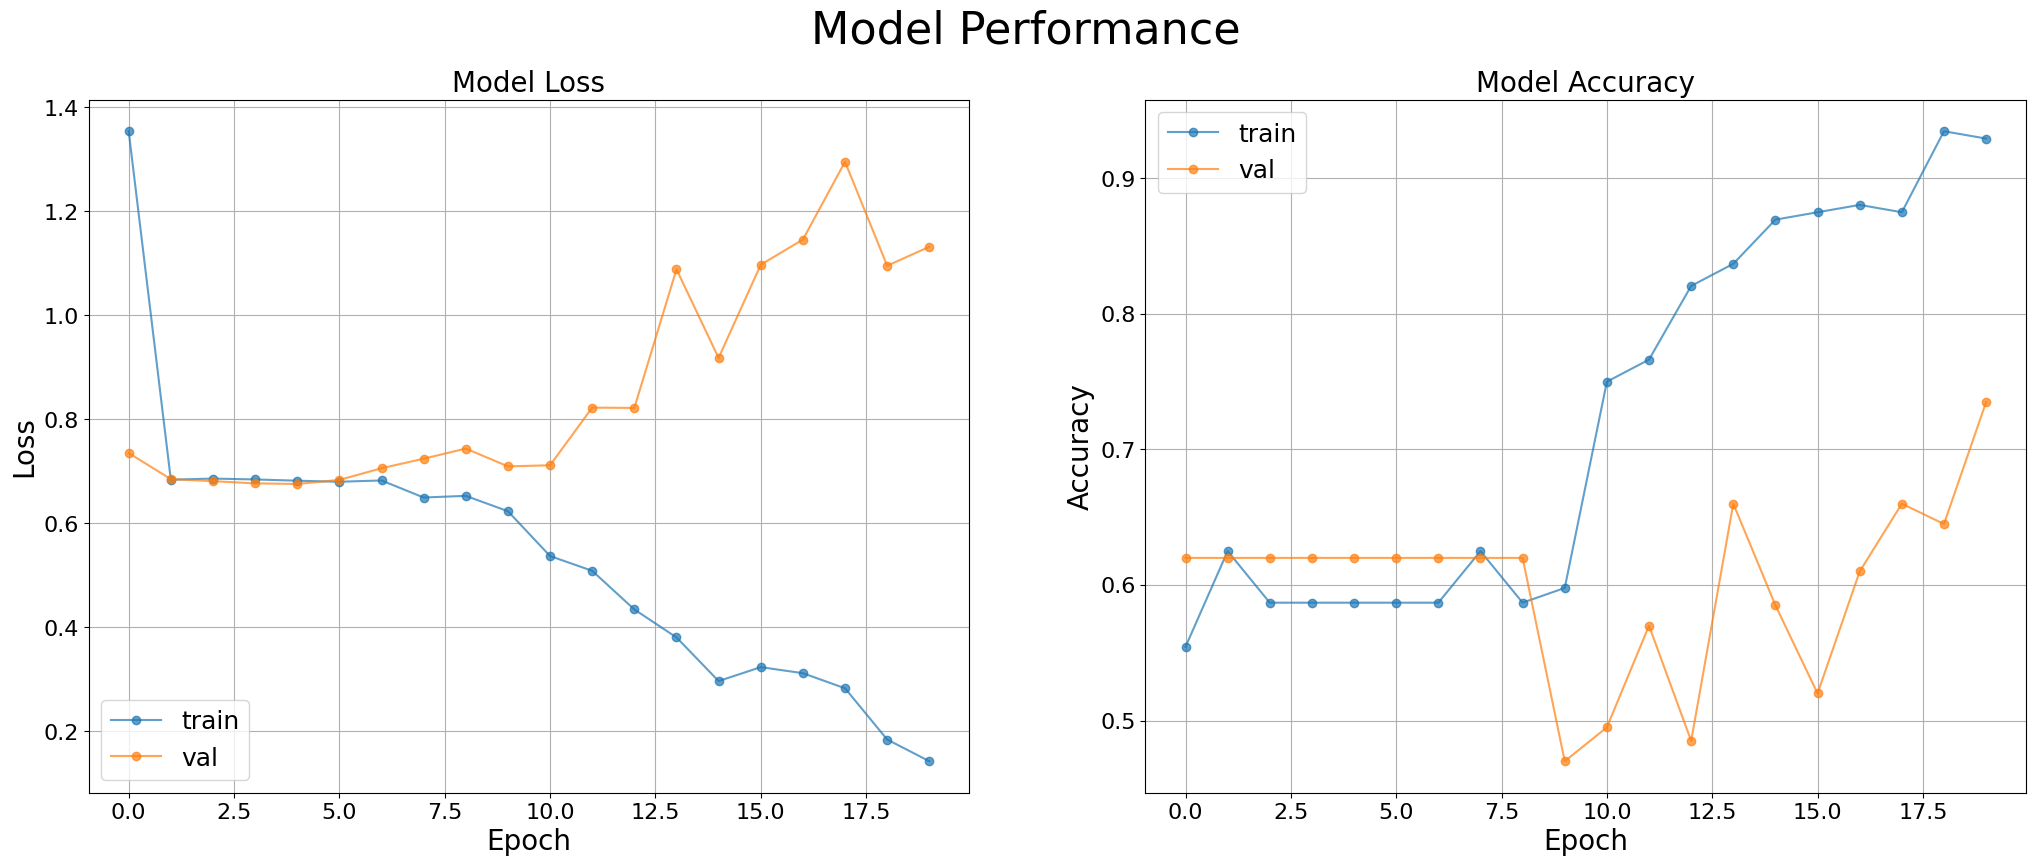

In [66]:
plt.figure(figsize=(25,9))
plt.subplot(1,2,1)
plot_losses(train_losses, val_losses)
plt.subplot(1,2,2)
plot_accuracies(train_accuracies, val_accuracies)
plt.suptitle("Model Performance", fontsize=32)

## Prediction visualization

In [67]:
model.eval()
def predict(test_dl, model):
  for i, (imgs, targets) in enumerate(test_dl):
    imgs = imgs.to(device, dtype = torch.float)
    preds = model(imgs).detach()
    preds = torch.round(torch.sigmoid(preds)).flatten().to('cpu') #flatten output
    return imgs, preds, targets

In [68]:
imgs, preds, targets = predict(test_dataloader, model)

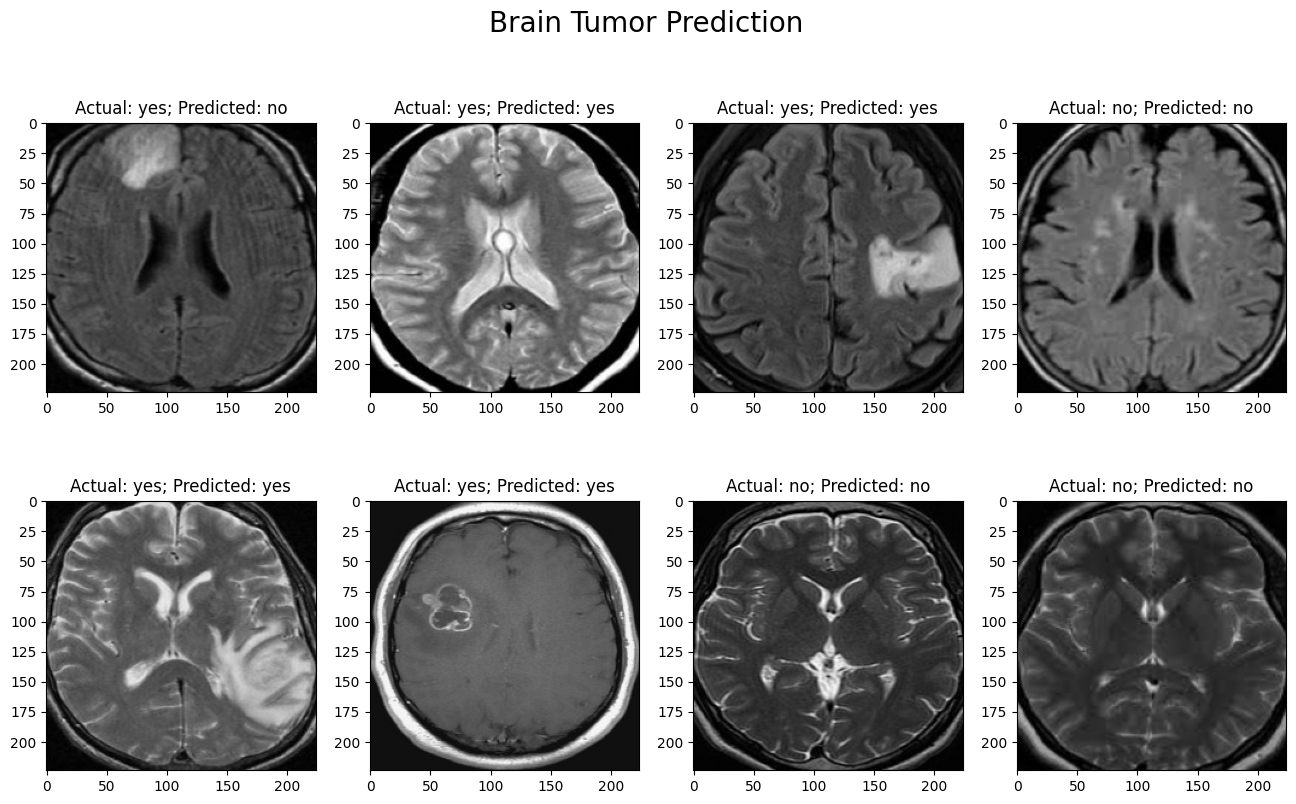

In [69]:
mapping = {0:'no',1:'yes'}
fig = plt.figure(figsize=(16,9))
for i in range(8):
  img = imgs[i].cpu() # send to cpu
  plt.subplot(2,4,i+1)
  plt.imshow(img.permute(1,2,0))
  plt.title(f'Actual: {mapping[targets[i].item()]}; Predicted: {mapping[preds[i].item()]}')
plt.suptitle("Brain Tumor Prediction", fontsize=20)
plt.show()

# Conclusions:



Congratulation! You have successfully completed the assignment! ✅

# References
[Original Brain Tumor data](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/code?datasetId=165566&sortBy=voteCount)

[EDA]( https://www.kaggle.com/code/ruslankl/brain-tumor-detection-v1-0-cnn-vgg-16)

[CNN model](https://www.kaggle.com/code/shreydan/brain-tumor-mri-detection-pytorch-cnn-83)

[Model performance](https://www.kaggle.com/code/nghihuynh/cifar-10-mlp-cnn-resnet9-classifier)